In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## load data

In [2]:
train_df = pd.read_csv('https://datahack-prod.s3.amazonaws.com/train_file/train_Jwzb8Zk.csv')
test_df = pd.read_csv('https://datahack-prod.s3.amazonaws.com/test_file/test_ocLJSTx.csv')
sample = pd.read_csv('https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_GTQ8kmH.csv')

In [3]:
sample.head(2)

,Emp_ID,Target
0,394,0
1,173,0


In [4]:
print('Train size: ', train_df.shape)
print('Test size: ', test_df.shape)

Train size:  (19104, 13)
Test size:  (741, 1)


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MMM-YY                19104 non-null  object
 1   Emp_ID                19104 non-null  int64 
 2   Age                   19104 non-null  int64 
 3   Gender                19104 non-null  object
 4   City                  19104 non-null  object
 5   Education_Level       19104 non-null  object
 6   Salary                19104 non-null  int64 
 7   Dateofjoining         19104 non-null  object
 8   LastWorkingDate       1616 non-null   object
 9   Joining Designation   19104 non-null  int64 
 10  Designation           19104 non-null  int64 
 11  Total Business Value  19104 non-null  int64 
 12  Quarterly Rating      19104 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.9+ MB


only 8% churn in 2 years period

In [6]:
len(test_df['Emp_ID'].unique())

741

All employee_ids unique

In [7]:
test_df.head(2)

,Emp_ID
0,394
1,173


In [8]:
train_df.describe()

,Emp_ID,Age,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating
count,19104.000000,19104.000000,19104.000000,19104.000000,19104.000000,1.910400e+04,19104.000000
mean,1415.591133,34.650283,65652.025126,1.690536,2.252670,5.716621e+05,2.008899
std,810.705321,6.264471,30914.515344,0.836984,1.026512,1.128312e+06,1.009832
min,1.000000,21.000000,10747.000000,1.000000,1.000000,-6.000000e+06,1.000000
25%,710.000000,30.000000,42383.000000,1.000000,1.000000,0.000000e+00,1.000000
50%,1417.000000,34.000000,60087.000000,1.000000,2.000000,2.500000e+05,2.000000
75%,2137.000000,39.000000,83969.000000,2.000000,3.000000,6.997000e+05,3.000000
max,2788.000000,58.000000,188418.000000,5.000000,5.000000,3.374772e+07,4.000000


In [9]:
train_df.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1


## Data Preprocessing

Check if employee_ids in train and test is the same, and if there are new employees in test

In [10]:
print('Unique employees in train: ', len(train_df['Emp_ID'].unique()))
print('Employee which stayed in the company:', len(train_df['Emp_ID'].unique()) - train_df['LastWorkingDate'].count())

# check if test has new employee_id
for i in set(test_df['Emp_ID'].unique()):
  if i not in set(train_df['Emp_ID'].unique()):
    print('new employee:', i)

Unique employees in train:  2381
Employee which stayed in the company: 765


categorical features:

In [11]:
cat_features = ['Gender', 'City', 'Education_Level', 'Joining Designation', 'Designation']

fiter those who left

In [12]:
left = train_df[train_df['LastWorkingDate'].isnull()==False]

Group bt employees

In [13]:
grouped_date = train_df.groupby('Emp_ID').agg({'MMM-YY':['min', 'max'], 
                                               'Dateofjoining': 'min'})
grouped_date.columns = ['min_my', 'max_my', 'join_date']
grouped_date.head(3)

,min_my,max_my,join_date
Emp_ID,,,
1,2016-01-01,2016-03-01,2015-12-24
2,2017-11-01,2017-12-01,2017-11-06
4,2016-12-01,2017-04-01,2016-12-07


In [14]:
grouped_churn = train_df.groupby('Emp_ID')[['MMM-YY','LastWorkingDate']].count()
grouped_churn.head(2)

,MMM-YY,LastWorkingDate
Emp_ID,,
1,3,1
2,2,0


In [15]:
grouped_mean = train_df.groupby('Emp_ID').mean()
grouped_mean.head(2)

,Age,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating
Emp_ID,,,,,,
1,28.0,57387.0,1.0,1.0,571860.0,2.0
2,31.0,67016.0,2.0,2.0,0.0,1.0


Find the difference in join_date and last_date - total months was employeed

In [27]:
grouped = grouped_date.merge(grouped_churn, on='Emp_ID', how='outer') \
                      .merge(grouped_mean, on='Emp_ID', how='outer') \
                      .merge(left[['Emp_ID', 'LastWorkingDate']], on='Emp_ID', how='outer') \
                      .set_index('Emp_ID')
grouped.head(3)

,min_my,max_my,join_date,MMM-YY,LastWorkingDate_x,Age,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,LastWorkingDate_y
Emp_ID,,,,,,,,,,,,
1,2016-01-01,2016-03-01,2015-12-24,3,1,28.0,57387.0,1.0,1.0,571860.0,2.0,2016-03-11
2,2017-11-01,2017-12-01,2017-11-06,2,0,31.0,67016.0,2.0,2.0,0.0,1.0,NaN
4,2016-12-01,2017-04-01,2016-12-07,5,1,43.0,65603.0,2.0,2.0,70000.0,1.0,2017-04-27


In [31]:
grouped['LastWorkingDate_y'].fillna('2017-12-01')
#grouped['total_m'] = grouped['LastWorkingDate_y'] - grouped['join_date']
grouped.head(3)

,min_my,max_my,join_date,MMM-YY,LastWorkingDate_x,Age,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,LastWorkingDate_y
Emp_ID,,,,,,,,,,,,
1,2016-01-01,2016-03-01,2015-12-24,3,1,28.0,57387.0,1.0,1.0,571860.0,2.0,2016-03-11
2,2017-11-01,2017-12-01,2017-11-06,2,0,31.0,67016.0,2.0,2.0,0.0,1.0,NaN
4,2016-12-01,2017-04-01,2016-12-07,5,1,43.0,65603.0,2.0,2.0,70000.0,1.0,2017-04-27


Take period of last 6 months

In [23]:
last_six_months = train_df[train_df['MMM-YY'] >= '2017-07-01']
last_six_months.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
13,2017-08-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,3,0,1
14,2017-09-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,3,0,1
15,2017-10-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,3,0,2


## Analysis

distribution of catigorical features

In [51]:
for i in cat_features:
    print(i,train_df[i].value_counts(normalize=True), sep='\n', end='\n\n')

Gender
Male      0.581187
Female    0.418813
Name: Gender, dtype: float64

City
C20    0.052764
C29    0.047111
C26    0.045488
C22    0.042347
C27    0.041143
C15    0.039835
C10    0.038945
C12    0.038055
C8     0.037270
C16    0.037113
C28    0.035752
C1     0.035438
C6     0.034548
C5     0.034338
C14    0.033920
C3     0.033344
C24    0.032140
C7     0.031878
C21    0.031564
C25    0.030570
C19    0.030308
C4     0.030255
C13    0.029784
C18    0.028476
C23    0.028162
C9     0.027219
C2     0.024707
C11    0.024497
C17    0.023032
Name: City, dtype: float64

Education_Level
Bachelor    0.359296
Master      0.331187
College     0.309516
Name: Education_Level, dtype: float64

Joining Designation
1    0.514604
2    0.311715
3    0.149026
4    0.017850
5    0.006805
Name: Joining Designation, dtype: float64

Designation
2    0.346891
1    0.272299
3    0.252617
4    0.112228
5    0.015965
Name: Designation, dtype: float64



- distribution of Education_Level looks the same, so this feature can be deleted
- Joining Designation and Designation is different, does it mean that someone got promoted or just changed profession?

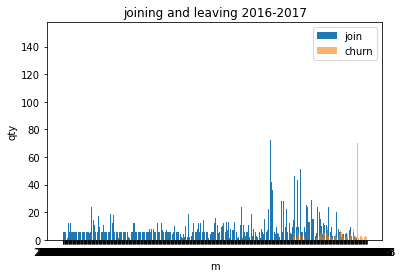

In [14]:
# Построим график регистрации и закрытия
ax = plt.gca()
ax.bar(last_six_months.groupby('Dateofjoining')['Emp_ID'].count().index, last_six_months.groupby('Dateofjoining')['Emp_ID'].count().values)
ax.bar(last_six_months.groupby('LastWorkingDate')['Emp_ID'].count().index, last_six_months.groupby('LastWorkingDate')['Emp_ID'].count().values, alpha=0.6)
ax.legend(['join','churn'])
ax.set_title('joining and leaving 2016-2017')
ax.set(ylabel='qty', xlabel='m')
plt.show()

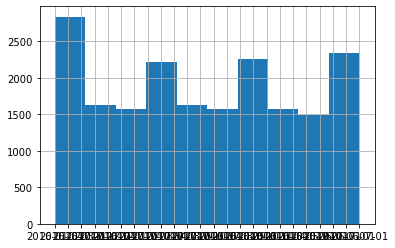

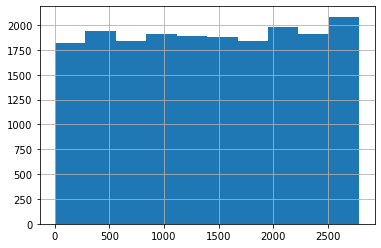

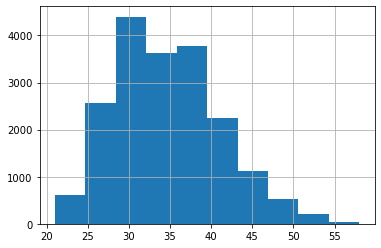

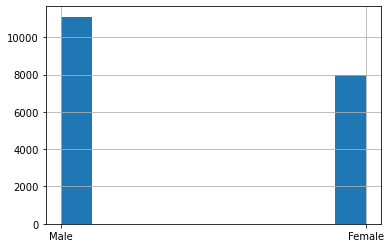

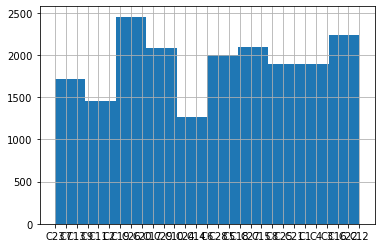

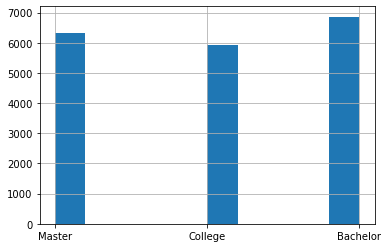

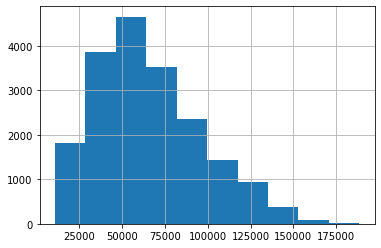

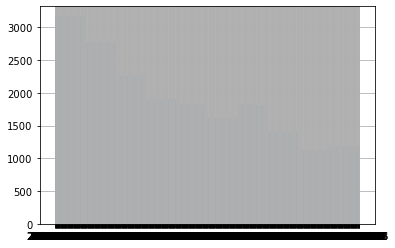

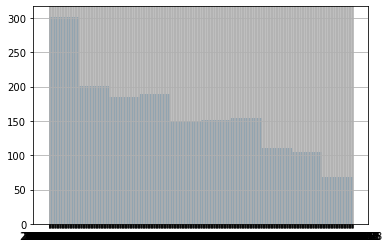

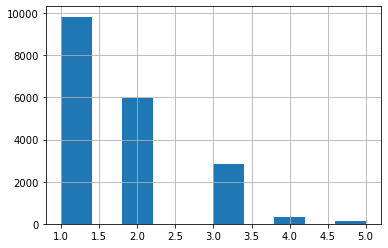

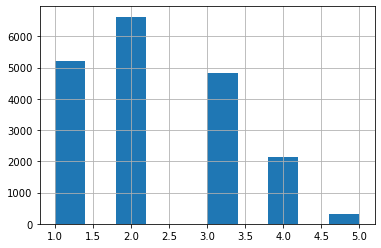

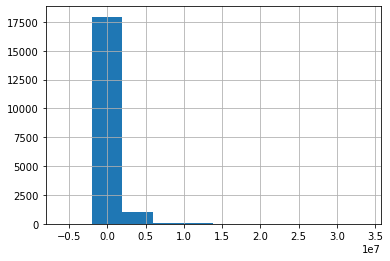

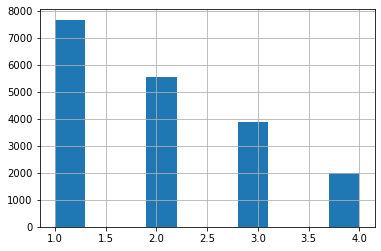

In [17]:
for i in train_df.columns:
    train_df[i].hist()
    plt.show()